### Patrick Horlaville (260931235) - Problem Set 4 - PHYS 512 : Computational Physics with Applications

Prof: Jon Sievers. TAs: Marcus Merryfield, Rigel Zifkin, Daniel Coelho

In [3]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import astropy.units as un

## Problem 1

a)

We first load the data

In [4]:
data = np.load('sidebands.npz')
t = data['time']
d = data['signal']

(array([-5.0e-05,  0.0e+00,  5.0e-05,  1.0e-04,  1.5e-04,  2.0e-04,
         2.5e-04,  3.0e-04,  3.5e-04,  4.0e-04,  4.5e-04]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

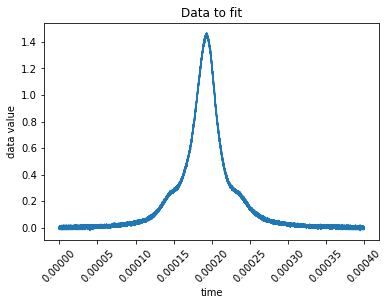

In [5]:
plt.plot(t, d)
plt.xlabel('time')
plt.ylabel('data value')
plt.title('Data to fit')
plt.xticks(rotation = 45)

Now we would like to model the data as a single Lorentzian and use analytic derivatives. To do so, we use Newton's method to carry out the fit. We parametrize the Lorentzian as $d = \frac{a}{1 + (t - t_0)^2/\omega^2}$

From the data, we can come up with initial guesses for the different parameters we will use: amplitude $a$ ~ 1.4, peak location $t_0$ ~ 0.00019 and peak spread $\omega$ ~ 0.00001

In [6]:
p0 = np.array([1.4, 0.00019, 0.00001])

Use code snippet from "newton.py" from the modelling directory, adapting it to the form of the model we are using for $d$:

In [7]:
def lorentz_d(p, t):
    
    a, t0, w = p[0], p[1], p[2]
    y = a/(1 + ((t - t0)/w)**2)
    grad = np.zeros([t.size, p.size])

    grad[:,0] = 1.0/(p[1] + (t - p[2])**2)
    grad[:,1] = - p[0]/(p[1] + (t - p[2])**2)**2
    grad[:,2] = p[0]*2*(t - p[2])/(p[1] + (t - p[2])**2)**2
    
    return y, grad

In [8]:
def newtons_method_lorentz(p, t):
    
    y_true = data['signal']
    
    new_ps = p

    for i in range(100):
        pred, grad = lorentz_d(new_ps, t)  
        res = y_true - pred  
        res = np.matrix(res).T
        grad = np.matrix(grad)
        dp = np.linalg.pinv(grad.T*grad)*(grad.T*res)
 
        for i in range(len(new_ps)):
            new_ps[i] += dp[i]
        new_ps = np.asarray(new_ps)
        
    return new_ps

In [9]:
p_new1a = newtons_method_lorentz(p0, t)

In [10]:
y1a, grad1a = lorentz_d(p_new1a, t)

Parameters found: a = 1.3999999965497165 , t_0 = 0.0001898262518406272 , omega = -1.4119742103716972e-05


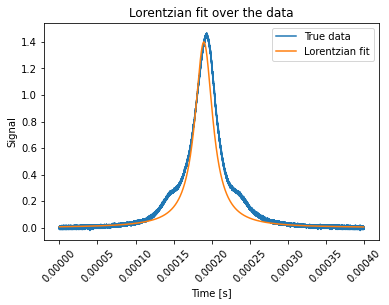

In [11]:
plt.plot(t, d, label = 'True data')
plt.plot(t, y1a, label = 'Lorentzian fit')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.title('Lorentzian fit over the data')
plt.legend()
plt.xticks(rotation = 45)
print('Parameters found: a =', p_new1a[0], ', t_0 =', p_new1a[1], ', omega =', p_new1a[2])

Text(0.5, 0, 'Time [s]')

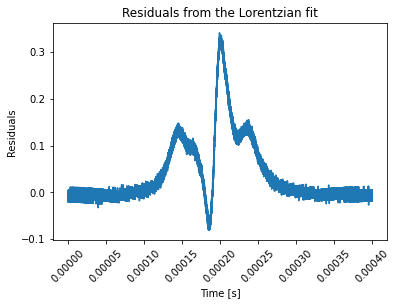

In [12]:
plt.plot(t, d - y1a)
plt.xticks(rotation = 45)
plt.title('Residuals from the Lorentzian fit')
plt.ylabel('Residuals')
plt.xlabel('Time [s]')

b)

Now we estimate the noise in the data, and from it, estimate the error on our parameters

In [13]:
sigma = np.std(d)
sc_sigma = sigma/np.sqrt(len(d))

In [14]:
cov_inv = np.eye(len(t))
np.fill_diagonal(cov_inv, 1/(sc_sigma**2))

The following code chunk doesn't work. The simple first matrix multiplication to be done in the 'cov' definition 
kills the kernel after a minute or two. After all, those are 100 000 by 100 000 matrices, but I don't know
if this was to be expected.

In [ ]:
'''
cov = np.linalg.pinv(grad1a.T@cov_inv@grad1a)
errs = np.sqrt(np.diag(cov))
print('The error on a is:', errs[0])
print('The error on t0 is:', errs[1])
print('The error on w is:', errs[2])
'''

I ended up managing to run the code to make the covariance matrix on another machine. So just pushed the array on github and I load it here!

In [15]:
cov = np.load("mycov1.npy")
errs = np.sqrt(np.diag(cov))
print('The error on a is:', errs[0])
print('The error on t0 is:', errs[1])
print('The error on w is:', errs[2])

The error on a is: 5.6170203222334366e-14
The error on t0 is: 1.7872142196859857e-13
The error on w is: 3.674885339197751e-10


The error seems to be particularly small compared to the accuracy of the fit to the data [c.f. previous plot]

c)

We repeat part a) but using numerical derivatives. First we define a derivative function, then we will have different f functions whose variable will be the different parameters. The derivative is taken with respect to the different parameters to have the gradients for each parameter (to do so, we use lambda functions. It helps in having to avoid defining many different functions. We only define three f functions that take as variable each parameter. We compute the gradient numerically with a derivative function). We take an arbitrarily small time step dt.

In [16]:
dt = 10**(-8)
deriv = lambda f, t: 1/(2*dt)*(f(t + dt) - f(t - dt))

In [17]:
def lorentz_num(p, t):
    
    a, t0, w = p[0], p[1], p[2]
    y = a/(1 + ((t - t0)/w)**2)

    f_a = lambda x: x/(1 + ((t - t0)/w)**2)
    f_t0 = lambda y: a/(1+((t - y)/w)**2)
    f_w = lambda z: a/(1+((t - t0)/z)**2)

    grad = np.zeros([len(t), len(p)])
    grad[:,0] = deriv(f_a, a)
    grad[:,1] = deriv(f_t0, t0)
    grad[:,2] = deriv(f_w, w)

    return y, grad

In [18]:
def newtons_method_lorentz_num(data, p, t, n):
    
    y_true = data['signal']
    new_ps = p
    
    for i in range(n):
        calc, grad = lorentz_num(new_ps, t)  
        res = y_true - calc  
        res = np.matrix(res).T  
        grad = np.matrix(grad)
        dp = np.linalg.pinv(grad.T*grad)*(grad.T*res)
 
        for i in range(len(new_ps)):
            new_ps[i] += dp[i]
        new_ps = np.asarray(new_ps)
        
    return new_ps

In [19]:
p_new1b = newtons_method_lorentz_num(data, p0, t, 500)
y1b, grad1b = lorentz_d(p_new1b, t)

Parameters found: a = 1.4228106821838835 , t_0 = 0.0001923586492623034 , omega = -1.792369075490326e-05


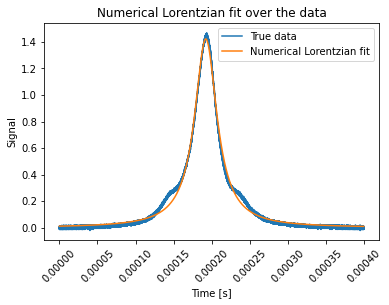

In [20]:
plt.plot(t, d, label = "True data")
plt.plot(t, y1b, label = "Numerical Lorentzian fit")
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.title('Numerical Lorentzian fit over the data')
plt.legend()
plt.xticks(rotation = 45)
print('Parameters found: a =', p_new1b[0], ', t_0 =', p_new1b[1], ', omega =', p_new1b[2])

Text(0.5, 0, 'Time [s]')

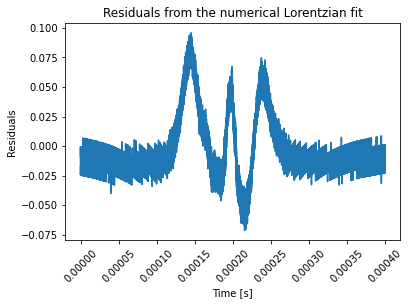

In [21]:
plt.plot(t, d - y1b)
plt.xticks(rotation = 45)
plt.title('Residuals from the numerical Lorentzian fit')
plt.ylabel('Residuals')
plt.xlabel('Time [s]')

The numerical derivatives approach yields similar parameters as in a), although the order of magnitude of discrepancy between the data and the fit seems to be lower than in a), as the comparison of the residuals' plot shows.

d)

Now we repeat part c) but we model the data as the addition of three Lorentzian functions. Very similarly, we define our lambda functions for each parameter and we define the gradient numerically with our deriv function.

In [22]:
def lorentzian_3lor(p, t):
    
    a, b, c, t0, t1, w = p
    y = a/(1 + ((t - t0)/w)**2) + b/(1 + ((t - t0 + t1)/w)**2) + c/(1 + ((t - t0 - t1)/w)**2)

    fa = lambda x1: x1/(1 + ((t - t0)/w)**2) + b/(1 + ((t - t0 + t1)/w)**2) + c/(1 + ((t - t0 - t1)/w)**2)
    fb = lambda x2: a/(1 + ((t - t0)/w)**2) + x2/(1 + ((t - t0 + t1)/w)**2) + c/(1 + ((t - t0 - t1)/w)**2)
    fc = lambda x3: a/(1 + ((t - t0)/w)**2) + b/(1 +((t - t0 + t1)/w)**2) + x3/(1 + ((t - t0 - t1)/w)**2)
    ft0 = lambda x4: a/(1 + ((t - x4)/w)**2) + b/(1 +((t - x4 + t1)/w)**2) + c/(1 + ((t - x4 - t1)/w)**2)
    ft1 = lambda x5: a/(1 + ((t - t0)/w)**2) + b/(1 + ((t - t0 + x5)/w)**2) + c/(1 + ((t - t0 - x5)/w)**2)
    fw = lambda x6: a/(1 + ((t - t0)/x6)**2) + b/(1 + ((t - t0 + t1)/x6)**2) + c/(1 + ((t - t0 - t1)/x6)**2)

    grad = np.zeros([len(t), len(p)])
    grad[:,0], grad[:,1], grad[:,2] = deriv(fa, a), deriv(fb, b), deriv(fc, c)
    grad[:,3], grad[:,4], grad[:,5] = deriv(ft0, t0), deriv(ft1, t1), deriv(fw, w)

    return y, grad

In [23]:
def newtons_method_3lor(data, p, t, n):
    
    y_true = data['signal']
    p_new = p
    
    for i in range(n):
        calc, grad = lorentzian_3lor(p_new, t)  
        res = y_true - calc  
        res = np.matrix(res).T
        grad = np.matrix(grad)
        dp = np.linalg.pinv(grad.T*grad)*(grad.T*res)
 
        for i in range(len(p_new)):
            p_new[i] += dp[i]
            
        p_new = np.asarray(p_new)
        
    return p_new

We need to have estimates for the amplitude of the two other Lorentzian peaks, which from the data plot seem to be of order ~ 0.3, and their distance from the main peak seems to be of order ~ 0.00005

In [24]:
p0_3lor= np.array([1.5, 0.3, 0.3, 0.00019, 0.00005, 0.00001])
p_new1d = newtons_method_3lor(data, p0_3lor, t, 100) 
y1d, grad1d = lorentzian_3lor(p_new1d, t)

In [25]:
print("The best-fit parameters for the sum of Lorentzians using numerical derivatives are:")
print("a:", p_new1d[0])
print("b:", p_new1d[1])
print("c:", p_new1d[2])
print("t0:", p_new1d[3])
print("t1:", p_new1d[4])
print("w:", p_new1d[5])

The best-fit parameters for the sum of Lorentzians using numerical derivatives are:
a: 1.4429923932697661
b: 0.10391077998946781
c: 0.06473253000825782
t0: 0.00019257852173624665
t1: 4.456716295451412e-05
w: 1.6065109423762263e-05


(array([-5.0e-05,  0.0e+00,  5.0e-05,  1.0e-04,  1.5e-04,  2.0e-04,
         2.5e-04,  3.0e-04,  3.5e-04,  4.0e-04,  4.5e-04]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

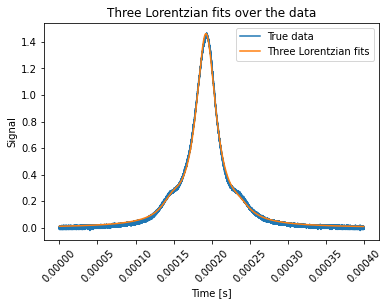

In [26]:
plt.plot(t, d, label = 'True data')
plt.plot(t, y1d, label = 'Three Lorentzian fits')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.title('Three Lorentzian fits over the data')
plt.legend()
plt.xticks(rotation = 45)

Text(0.5, 0, 'Time [s]')

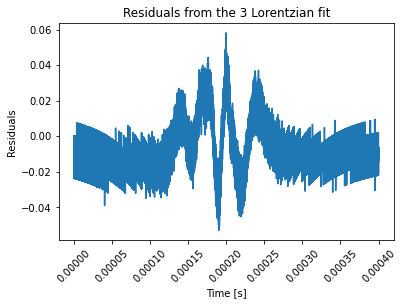

In [27]:
plt.plot(t, d - y1d)
plt.xticks(rotation = 45)
plt.title('Residuals from the 3 Lorentzian fit')
plt.ylabel('Residuals')
plt.xlabel('Time [s]')

Again, the code to compute the covariance matrix kills the kernel. Once more, I run it on another machine, put it on github and load it:

In [ ]:
'''
cov_d = np.linalg.pinv(grad1d.transpose()@cov_inv@grad1d)
errs_d = np.sqrt(np.diag(cov_d))
'''

In [28]:
cov_d = np.load("mycov_3lor.npy")
errs_d = np.sqrt(np.diag(cov_d))

In [29]:
print('Errors on parameters are:')
print('Error on a is:', errs_d[0])
print('Error on b is:', errs_d[1])
print('Error on c is:', errs_d[2])
print('Error on t0 is:', errs_d[3])
print('Error on t1 is:', errs_d[4])
print('Error on w is:', errs_d[5])

Errors on parameters are:
Error on a is: 1.9044456492900022e-05
Error on b is: 1.8164391307338086e-05
Error on c is: 1.7786013804857236e-05
Error on t0 is: 2.2547830597826696e-10
Error on t1 is: 2.718178487099205e-09
Error on w is: 4.0381245203269164e-10


Again, the error on the parameters seems underestimated, although given the errors here are in general bigger than in a) and given the fit is much better than in a), that discrepancy does not seem to be as important.

e)

Here we look at the residuals from the calculated fit found in d)

(array([-5.0e-05,  0.0e+00,  5.0e-05,  1.0e-04,  1.5e-04,  2.0e-04,
         2.5e-04,  3.0e-04,  3.5e-04,  4.0e-04,  4.5e-04]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

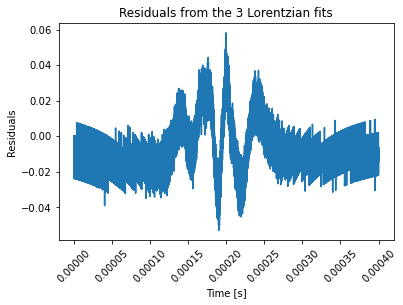

In [30]:
plt.plot(t, d - y1d)
plt.title('Residuals from the 3 Lorentzian fits')
plt.xlabel('Time [s]')
plt.ylabel('Residuals')
plt.xticks(rotation = 45)

The look of the residuals does not look much random, rather it seems there is still some structure to it, especially near the peak. It is hence fair to say that our model of the three Lorentzian could be upgraded, and that it models our data in a limited fashion given the structure of the residuals. However, our current model is not that bad, with the structure having an amplitude of order ~ 0.04.

f)

Now we perturbate our parameters found in d) with the errors and the covariance matrix. Then we can compute the $\chi^2$ for each of those and if the model is well behaved, the $\chi^2$ should be similar between the different realizations.

In [1]:
n = 50

chisqs = [0 for i in range(n)]

'''
res_1d = d - y1d
chisq_1d = res_1d.T@cov_inv@res_1d

for i in range(n):
    
    p_pert = p_new1d + cov_d@np.random.randn(len(p_new1d))
    y_pert, grad_pert = lorentzian_3lor(p_pert, t)
    res_pert = d - y_pert
    
    chisqs[i] = res_pert.T@cov_inv@res_pert 
'''

'\nfor i in range(n):\n    \n    p_pert = p_new1d + cov_d@np.random.randn(len(p_new1d))\n    y_pert, grad_pert = lorentzian_3lor(p_pert, t)\n    res_pert = d - y_pert\n    \n    chisqs[i] = res_pert.T@cov_inv@res_pert \n'

g)